# Clustering, Modeling and Visualizing Features

We will be using a 1700+ row dataset collected from the Spotify API and consisting of songs from a playlist from DJ and producer Four Tet, which can be found in the above CSV file. The dataset consists of descriptive metadata (track name, artist name) as well as numerical audio features which we will use for modeling (acousticness, danceability, duration, energy, instrumentalness, liveness, loudness, tempo and valence).

After fitting our model we will test it on two additional smaller playlists: Spotify's "Songs to Sing in the Shower" (200 rows) and Max Richter's "Kitchen Playlist" (78 songs).

Below we will import modules to be used.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score, plot_confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
%matplotlib inline
from lime import lime_tabular

In [2]:
df = pd.read_csv('fourtet.csv')
df.head()

Unnamed: 0                                     track_name  \
0           0  My Friend of Misery - From Jason's Riff Tapes   
1           1                           Magnet Pulls Through   
2           2                         Houston in Two Seconds   
3           3                         Lost in A Lonely World   
4           4                              Conducted Rhythms   

                                   album      artist_name release_date  \
0  Metallica (Remastered Deluxe Box Set)        Metallica   2021-09-10   
1                               Tortoise         Tortoise   1994-09-01   
2                     Music by Ry Cooder        Ry Cooder         1995   
3                 The Best of the Ethics       The Ethics   2003-01-01   
4      Peanut Butter Wolf's Jukebox 45's  Various Artists   2002-09-01   

   duration_ms  popularity  danceability  acousticness  energy  \
0       277892          42         0.750         0.874  0.2100   
1       278040          22         0.541         0.133  0.2450   
2       121826          32         0.256         0.917  0.0458   
3       154866          40         0.504         0.920  0.1160   
4       111000           0         0.827         0.323  0.4720   

   instrumentalness  liveness  loudness  speechiness    tempo  valence  
0            0.9420     0.111   -19.358       0.0368  109.650   0.4990  
1            0.7950     0.110   -17.452       0.0339   68.398   0.0435  
2            0.0419     0.125   -23.396       0.0602  171.818   0.1200  
3            0.0706     0.103   -11.122       0.0351  105.175   0.1950  
4            0.6160     0.560    -7.085       0.3300  105.942   0.8200

Importing DataFrame and checking for null values and descriptive statistics.

In [3]:
df.isna().sum()

Unnamed: 0          0
track_name          0
album               0
artist_name         0
release_date        0
duration_ms         0
popularity          0
danceability        0
acousticness        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
dtype: int64

In [4]:
df.describe()

Unnamed: 0   duration_ms   popularity  danceability  acousticness  \
count  1749.000000  1.749000e+03  1749.000000   1749.000000   1749.000000   
mean    874.000000  3.025054e+05    14.173814      0.573177      0.422119   
std     505.037127  1.791806e+05    15.253037      0.202864      0.368637   
min       0.000000  1.895700e+04     0.000000      0.000000      0.000002   
25%     437.000000  1.920000e+05     0.000000      0.426000      0.047700   
50%     874.000000  2.710530e+05     9.000000      0.595000      0.334000   
75%    1311.000000  3.676640e+05    23.000000      0.745000      0.805000   
max    1748.000000  2.241200e+06    71.000000      0.980000      0.996000   

            energy  instrumentalness     liveness     loudness  speechiness  \
count  1749.000000       1749.000000  1749.000000  1749.000000  1749.000000   
mean      0.536230          0.504110     0.163499   -12.556360     0.097535   
std       0.257424          0.389365     0.137297     5.646474     0.109528   
min       0.000281          0.000000     0.020600   -37.114000     0.000000   
25%       0.343000          0.018900     0.090200   -15.286000     0.040200   
50%       0.560000          0.656000     0.111000   -11.315000     0.056200   
75%       0.749000          0.880000     0.172000    -8.498000     0.099500   
max       0.999000          0.984000     0.993000    -1.987000     0.947000   

             tempo      valence  
count  1749.000000  1749.000000  
mean    119.239222     0.426432  
std      27.410275     0.275130  
min       0.000000     0.000000  
25%      99.956000     0.178000  
50%     121.008000     0.398000  
75%     133.994000     0.660000  
max     210.029000     0.996000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1749 non-null   int64  
 1   track_name        1749 non-null   object 
 2   album             1749 non-null   object 
 3   artist_name       1749 non-null   object 
 4   release_date      1749 non-null   object 
 5   duration_ms       1749 non-null   int64  
 6   popularity        1749 non-null   int64  
 7   danceability      1749 non-null   float64
 8   acousticness      1749 non-null   float64
 9   energy            1749 non-null   float64
 10  instrumentalness  1749 non-null   float64
 11  liveness          1749 non-null   float64
 12  loudness          1749 non-null   float64
 13  speechiness       1749 non-null   float64
 14  tempo             1749 non-null   float64
 15  valence           1749 non-null   float64
dtypes: float64(9), int64(3), object(4)
memory 

Not being an audio feature, we can drop the 'popularity' column.

In [6]:
df = df.drop(['popularity', 'Unnamed: 0'], axis=1)
df

track_name  \
0     My Friend of Misery - From Jason's Riff Tapes   
1                              Magnet Pulls Through   
2                            Houston in Two Seconds   
3                            Lost in A Lonely World   
4                                 Conducted Rhythms   
...                                             ...   
1744                                  Es war einmal   
1745                                      Kinoshita   
1746                          Promises Of Fertility   
1747                                              3   
1748                         Earth's Magnetic Field   

                                                  album      artist_name  \
0                 Metallica (Remastered Deluxe Box Set)        Metallica   
1                                              Tortoise         Tortoise   
2                                    Music by Ry Cooder        Ry Cooder   
3                                The Best of the Ethics       The Ethics   
4                     Peanut Butter Wolf's Jukebox 45's  Various Artists   
...                                                 ...              ...   
1744                                          Sowiesoso          Cluster   
1745                                        Eph Reissue           Fridge   
1746  For Those Of You Who Have Never (And Also Thos...        Huerco S.   
1747                                            Get Out             Pita   
1748  Columbia-Princeton Electronic Music Center 196...  Various Artists   

     release_date  duration_ms  danceability  acousticness   energy  \
0      2021-09-10       277892         0.750       0.87400  0.21000   
1      1994-09-01       278040         0.541       0.13300  0.24500   
2            1995       121826         0.256       0.91700  0.04580   
3      2003-01-01       154866         0.504       0.92000  0.11600   
4      2002-09-01       111000         0.827       0.32300  0.47200   
...           ...          ...           ...           ...      ...   
1744         1976       325400         0.643       0.75800  0.15600   
1745   2002-05-07       302693         0.623       0.13200  0.94500   
1746   2016-06-10       415933         0.260       0.82100  0.28400   
1747   2008-05-12       678080         0.228       0.00869  0.61900   
1748   1998-01-01       848266         0.282       0.97400  0.00385   

      instrumentalness  liveness  loudness  speechiness    tempo  valence  
0               0.9420    0.1110   -19.358       0.0368  109.650   0.4990  
1               0.7950    0.1100   -17.452       0.0339   68.398   0.0435  
2               0.0419    0.1250   -23.396       0.0602  171.818   0.1200  
3               0.0706    0.1030   -11.122       0.0351  105.175   0.1950  
4               0.6160    0.5600    -7.085       0.3300  105.942   0.8200  
...                ...       ...       ...          ...      ...      ...  
1744            0.9760    0.1040   -20.074       0.0419  117.372   0.3140  
1745            0.8950    0.3020    -5.775       0.0984  139.971   0.6110  
1746            0.8410    0.1100   -19.656       0.0367   61.829   0.4250  
1747            0.9280    0.1540    -7.414       0.0483  105.538   0.2070  
1748            0.0023    0.0798   -19.061       0.0575   60.470   0.3490  

[1749 rows x 14 columns]

We will select our numerical values for modeling and store them in the variable X.

In [7]:
X = df.select_dtypes(np.number)
X

duration_ms  danceability  acousticness   energy  instrumentalness  \
0          277892         0.750       0.87400  0.21000            0.9420   
1          278040         0.541       0.13300  0.24500            0.7950   
2          121826         0.256       0.91700  0.04580            0.0419   
3          154866         0.504       0.92000  0.11600            0.0706   
4          111000         0.827       0.32300  0.47200            0.6160   
...           ...           ...           ...      ...               ...   
1744       325400         0.643       0.75800  0.15600            0.9760   
1745       302693         0.623       0.13200  0.94500            0.8950   
1746       415933         0.260       0.82100  0.28400            0.8410   
1747       678080         0.228       0.00869  0.61900            0.9280   
1748       848266         0.282       0.97400  0.00385            0.0023   

      liveness  loudness  speechiness    tempo  valence  
0       0.1110   -19.358       0.0368  109.650   0.4990  
1       0.1100   -17.452       0.0339   68.398   0.0435  
2       0.1250   -23.396       0.0602  171.818   0.1200  
3       0.1030   -11.122       0.0351  105.175   0.1950  
4       0.5600    -7.085       0.3300  105.942   0.8200  
...        ...       ...          ...      ...      ...  
1744    0.1040   -20.074       0.0419  117.372   0.3140  
1745    0.3020    -5.775       0.0984  139.971   0.6110  
1746    0.1100   -19.656       0.0367   61.829   0.4250  
1747    0.1540    -7.414       0.0483  105.538   0.2070  
1748    0.0798   -19.061       0.0575   60.470   0.3490  

[1749 rows x 10 columns]

With KMeans we can find the optimal number of clusters using the elbow method.

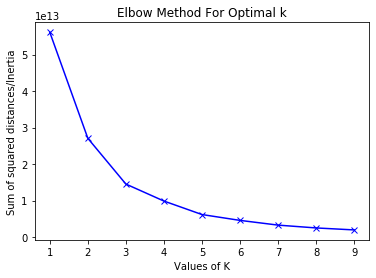

In [8]:
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

It appears the optimal K is right around 3 so we will scale and fit our numeric data.

In [9]:
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=3, verbose=2))])
cluster_pipeline.fit(X)

Initialization complete
Iteration 0, inertia 21143.508500767624
Iteration 1, inertia 13443.899706900062
Iteration 2, inertia 13152.893528191302
Iteration 3, inertia 12825.546393552977
Iteration 4, inertia 12492.051904528096
Iteration 5, inertia 12345.219831078371
Iteration 6, inertia 12289.553212307632
Iteration 7, inertia 12273.58040604768
Iteration 8, inertia 12270.435276422208
Iteration 9, inertia 12269.610450302562
Iteration 10, inertia 12269.398503995606
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 20259.972386231715
Iteration 1, inertia 13974.004408382047
Iteration 2, inertia 13467.966911929796
Iteration 3, inertia 13297.638332273147
Iteration 4, inertia 13195.277659136516
Iteration 5, inertia 13083.34460298517
Iteration 6, inertia 12965.272789854265
Iteration 7, inertia 12870.678038209302
Iteration 8, inertia 12741.202875925905
Iteration 9, inertia 12596.22424346179
Iteration 10, inertia 12463.624977272222
Iteration 11, inertia 1237

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, verbose=2))])

In [10]:
cluster_labels = cluster_pipeline.predict(X)
df['cluster'] = cluster_labels
df['cluster'].value_counts()

1    647
2    552
0    550
Name: cluster, dtype: int64

We have three similarly sized clusters. We can reduce dimentionality using Principal Component Analysis, fit and visualize our data using a Plotly hover plot. 

In [11]:
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = df['track_name']
projection['artist'] = df['artist_name']
projection['cluster'] = df['cluster']
projection

x         y                                          title  \
0     1.635548  0.379433  My Friend of Misery - From Jason's Riff Tapes   
1     1.619235  0.650001                           Magnet Pulls Through   
2     3.067929 -0.495287                         Houston in Two Seconds   
3     1.800525 -0.976904                         Lost in A Lonely World   
4    -1.631911 -2.611840                              Conducted Rhythms   
...        ...       ...                                            ...   
1744  2.006184  0.849126                                  Es war einmal   
1745 -2.093137  0.626861                                      Kinoshita   
1746  2.736273  0.174917                          Promises Of Fertility   
1747 -0.030471  2.012045                                              3   
1748  3.080072 -0.331115                         Earth's Magnetic Field   

               artist  cluster  
0           Metallica        0  
1            Tortoise        0  
2           Ry Cooder        0  
3          The Ethics        0  
4     Various Artists        2  
...               ...      ...  
1744          Cluster        0  
1745           Fridge        1  
1746        Huerco S.        0  
1747             Pita        1  
1748  Various Artists        0  

[1749 rows x 5 columns]

In [12]:
fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title', 'artist'])
fig.show()

We can proceed to build a content-based recommendation system, however let's repeat the process with two clusters and visualize our results to see if we can build a clasifier and identify the model's most important features.

In [13]:
cluster_pipeline2 = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2, verbose=2))])
cluster_pipeline2.fit(X)

Initialization complete
Iteration 0, inertia 24740.691825931048
Iteration 1, inertia 13773.21034960372
Iteration 2, inertia 13722.27725185187
Iteration 3, inertia 13715.552817607193
Iteration 4, inertia 13713.880851285734
Iteration 5, inertia 13713.746955789578
Converged at iteration 5: center shift 4.0960534219398e-05 within tolerance 9.999999999999995e-05.
Initialization complete
Iteration 0, inertia 24228.72494585992
Iteration 1, inertia 14146.688245240442
Iteration 2, inertia 13817.94485985445
Iteration 3, inertia 13735.75455725796
Iteration 4, inertia 13717.409215434907
Iteration 5, inertia 13714.191664468357
Iteration 6, inertia 13713.763135689192
Converged at iteration 6: center shift 6.328205275621226e-05 within tolerance 9.999999999999995e-05.
Initialization complete
Iteration 0, inertia 21367.3932405771
Iteration 1, inertia 14239.742971886013
Iteration 2, inertia 13832.77997568956
Iteration 3, inertia 13741.064373821588
Iteration 4, inertia 13719.096542784113
Iteration 5, ine

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=2, verbose=2))])

In [14]:
cluster_labels2 = cluster_pipeline2.predict(X)
df['cluster2'] = cluster_labels2
df['cluster2'].value_counts()

0    1140
1     609
Name: cluster2, dtype: int64

In [15]:
pca_pipeline2 = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding2 = pca_pipeline2.fit_transform(X)
projection2 = pd.DataFrame(columns=['x', 'y'], data=song_embedding2)
projection2['title'] = df['track_name']
projection2['artist'] = df['artist_name']
projection2['cluster2'] = df['cluster2']
projection2

x         y                                          title  \
0     1.635548  0.379433  My Friend of Misery - From Jason's Riff Tapes   
1     1.619235  0.650001                           Magnet Pulls Through   
2     3.067929 -0.495287                         Houston in Two Seconds   
3     1.800525 -0.976904                         Lost in A Lonely World   
4    -1.631911 -2.611840                              Conducted Rhythms   
...        ...       ...                                            ...   
1744  2.006184  0.849126                                  Es war einmal   
1745 -2.093137  0.626861                                      Kinoshita   
1746  2.736273  0.174917                          Promises Of Fertility   
1747 -0.030471  2.012045                                              3   
1748  3.080072 -0.331115                         Earth's Magnetic Field   

               artist  cluster2  
0           Metallica         1  
1            Tortoise         1  
2           Ry Cooder         1  
3          The Ethics         1  
4     Various Artists         0  
...               ...       ...  
1744          Cluster         1  
1745           Fridge         0  
1746        Huerco S.         1  
1747             Pita         0  
1748  Various Artists         1  

[1749 rows x 5 columns]

In [16]:
fig2 = px.scatter(projection2, x='x', y='y', color='cluster2', hover_data=['x', 'y', 'title', 'artist'])
fig2.show()

While our sample sizes are imbalanced, our cluster on the positive x-axis remains similar. A binary classification model focusing on accuracy can pinpoint which audio features are most important.

In [17]:
# Creating x and y variables, keeping numerical features only 
predictor_x = df.drop(columns=['track_name', 'album', 'artist_name', 'release_date', 'tempo', 'cluster', 'cluster2'], axis=1)
predictor_y = df.cluster2

In [18]:
def print_metrics(labels, preds):
    
    # Function to easily print results of training and test metrics
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [19]:
# Creating train and test sets, scaling and using SMOTE to adjust for imbalanced samples
X_train, X_test, y_train, y_test = train_test_split(predictor_x, predictor_y, test_size=.25,  random_state=42)
scaler = StandardScaler()
smote = SMOTE()

# Using Logistic Regression in pipeline to fit resampled sets
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
pipeline = make_pipeline(scaler, smote, logreg)
pipeline.fit(X_train_resampled, y_train_resampled)
train_pred = pipeline.predict(X_train_resampled)
test_pred = pipeline.predict(X_test)

# ROC AUC score and classification metrics followed by visualized confusion matrix
train_score = roc_auc_score(y_train_resampled, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print("Training Score: ", train_score)
print("Test Score: ", test_score)

Training Score:  0.9800936768149882
Test Score:  0.979849098270151


In [20]:
print("Training Metrics")
print(print_metrics(y_train_resampled, train_pred))
print('\n')
print("Testing Metrics")
print(print_metrics(y_test, test_pred))

Training Metrics
Precision Score: 0.9846335697399528
Recall Score: 0.9754098360655737
Accuracy Score: 0.9800936768149883
F1 Score: 0.9800000000000001
None


Testing Metrics
Precision Score: 0.9736842105263158
Recall Score: 0.9736842105263158
Accuracy Score: 0.9817351598173516
F1 Score: 0.9736842105263158
None


Confusion Matrices - Training and Test Sets


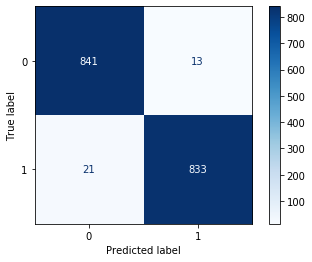

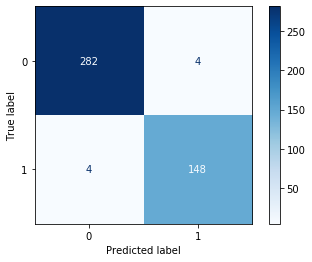

In [21]:
print("Confusion Matrices - Training and Test Sets")
plot_confusion_matrix(pipeline, X_train_resampled, y_train_resampled, cmap=plt.cm.Blues, values_format='.3g')
plot_confusion_matrix(pipeline, X_test, y_test, cmap=plt.cm.Blues, values_format='.3g')

In [22]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

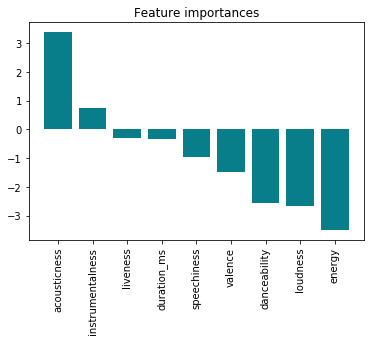

In [23]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

In [24]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['0', '1'],
    mode='classification'
)

In [45]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[0], 
    predict_fn=pipeline.predict_proba
)

In [46]:
exp.show_in_notebook(show_table=True)

We will test the model on two additional playlists.  First is Spotify's own "Songs to Sing in the Shower" playlist consisting of 200 songs. Following that will be Max Richter's classical-themed "Kitchen Playlist."

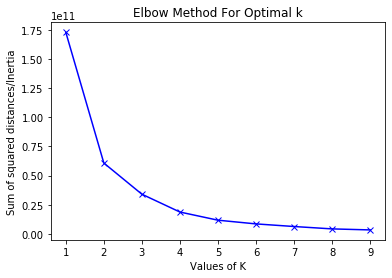

In [75]:
df_shower = pd.read_csv('showersongs.csv')
df_shower = df_shower.drop(['popularity', 'Unnamed: 0'], axis=1)
X_shower = df_shower.select_dtypes(np.number)
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X_shower)
 sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [76]:
cluster_pipeline3 = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])
cluster_pipeline3.fit(X_shower)

Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])

In [77]:
cluster_labels3 = cluster_pipeline3.predict(X_shower)
df_shower['cluster'] = cluster_labels3
df_shower['cluster'].value_counts()

1    147
0     53
Name: cluster, dtype: int64

In [78]:
pca_pipeline3 = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding3 = pca_pipeline3.fit_transform(X_shower)
projection3 = pd.DataFrame(columns=['x', 'y'], data=song_embedding3)
projection3['title'] = df_shower['track_name']
projection3['artist'] = df_shower['artist_name']
projection3['cluster'] = df_shower['cluster']
fig3 = px.scatter(projection3, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title', 'artist'])
fig3.show()

Although there are less data points here, a two-cluster model seems to work best.

In [85]:
# Creating x and y variables, keeping numerical features only 
predictor_x = df_shower.drop(columns=['track_name', 'album', 'artist_name', 'release_date', 'tempo', 'cluster'], axis=1)
predictor_y = df_shower.cluster

# Creating train and test sets, scaling and using SMOTE to adjust for imbalanced samples
X_train, X_test, y_train, y_test = train_test_split(predictor_x, predictor_y, test_size=.25,  random_state=42)
scaler = StandardScaler()

# Using Logistic Regression in pipeline to fit resampled sets
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
pipeline = make_pipeline(scaler, logreg)
pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

# ROC AUC score and classification metrics followed by visualized confusion matrix
train_score = roc_auc_score(y_train, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print("Training Score: ", train_score)
print("Test Score: ", test_score)

Training Score:  0.9622641509433962
Test Score:  0.9024390243902439


In [86]:
print("Training Metrics")
print(print_metrics(y_train, train_pred))
print('\n')
print("Testing Metrics")
print(print_metrics(y_test, test_pred))

Training Metrics
Precision Score: 1.0
Recall Score: 0.9245283018867925
Accuracy Score: 0.9466666666666667
F1 Score: 0.9607843137254902
None


Testing Metrics
Precision Score: 1.0
Recall Score: 0.8048780487804879
Accuracy Score: 0.84
F1 Score: 0.8918918918918919
None


Confusion Matrices - Training and Test Sets


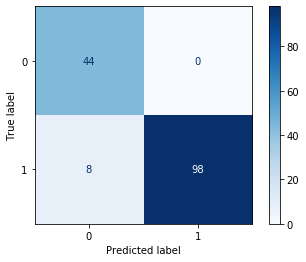

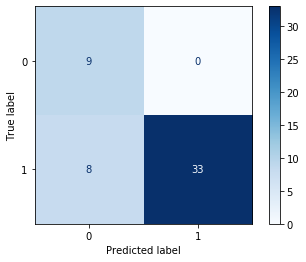

In [87]:
print("Confusion Matrices - Training and Test Sets")
plot_confusion_matrix(pipeline, X_train, y_train, cmap=plt.cm.Blues, values_format='.3g')
plot_confusion_matrix(pipeline, X_test, y_test, cmap=plt.cm.Blues, values_format='.3g')

In [88]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

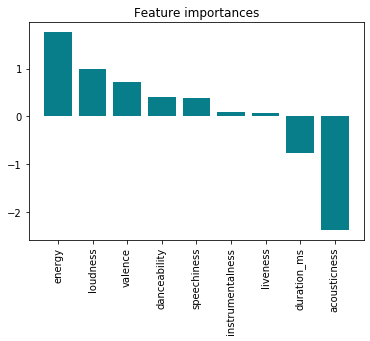

In [89]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

Despite the differences, our feature importances remain similar.

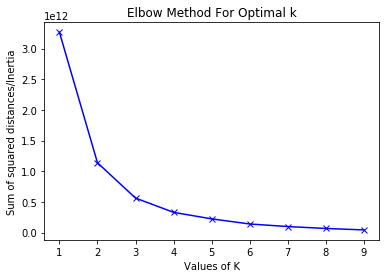

In [91]:
df_max = pd.read_csv('maxrichter.csv')
df_max = df_max.drop(['popularity', 'Unnamed: 0'], axis=1)
X_max = df_max.select_dtypes(np.number)
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X_max)
 sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [92]:
cluster_pipeline4 = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])
cluster_pipeline4.fit(X_max)

Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])

In [93]:
cluster_labels4 = cluster_pipeline4.predict(X_max)
df_max['cluster'] = cluster_labels4
df_max['cluster'].value_counts()

1    60
0    18
Name: cluster, dtype: int64

In [94]:
pca_pipeline4 = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding4 = pca_pipeline4.fit_transform(X_max)
projection4 = pd.DataFrame(columns=['x', 'y'], data=song_embedding4)
projection4['title'] = df_max['track_name']
projection4['artist'] = df_max['artist_name']
projection4['cluster'] = df_max['cluster']
fig4 = px.scatter(projection4, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title', 'artist'])
fig4.show()

In [96]:
# Creating x and y variables, keeping numerical features only 
predictor_x = df_max.drop(columns=['track_name', 'album', 'artist_name', 'release_date', 'tempo', 'cluster'], axis=1)
predictor_y = df_max.cluster

# Creating train and test sets, scaling and using SMOTE to adjust for imbalanced samples
X_train, X_test, y_train, y_test = train_test_split(predictor_x, predictor_y, test_size=.25,  random_state=42)
scaler = StandardScaler()

# Using Logistic Regression in pipeline to fit resampled sets
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
pipeline = make_pipeline(scaler, logreg)
pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

# ROC AUC score and classification metrics followed by visualized confusion matrix
train_score = roc_auc_score(y_train, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print("Training Score: ", train_score)
print("Test Score: ", test_score)

Training Score:  0.9659090909090908
Test Score:  0.9375


In [97]:
print("Training Metrics")
print(print_metrics(y_train, train_pred))
print('\n')
print("Testing Metrics")
print(print_metrics(y_test, test_pred))

Training Metrics
Precision Score: 1.0
Recall Score: 0.9318181818181818
Accuracy Score: 0.9482758620689655
F1 Score: 0.9647058823529412
None


Testing Metrics
Precision Score: 1.0
Recall Score: 0.875
Accuracy Score: 0.9
F1 Score: 0.9333333333333333
None


Confusion Matrices - Training and Test Sets


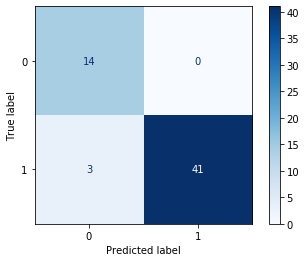

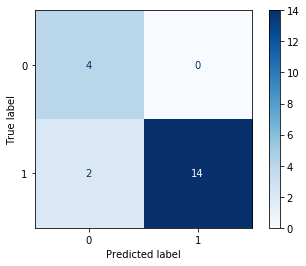

In [98]:
print("Confusion Matrices - Training and Test Sets")
plot_confusion_matrix(pipeline, X_train, y_train, cmap=plt.cm.Blues, values_format='.3g')
plot_confusion_matrix(pipeline, X_test, y_test, cmap=plt.cm.Blues, values_format='.3g')

In [99]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

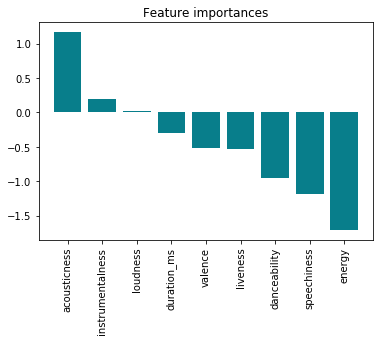

In [100]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

There are slight differences in feature importance here; this playlist is much shorter however a content-based recommendation system should still work despite the difference in recommended clusters.